# Nested Sampling with `dynesty`: Error Analysis

This is a simple interactive demo that outlines nested sampling error analysis in `dynesty`. See the [documentation](dynesty.readthedocs.io) for more details.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os
import copy

# basic numeric setup
import numpy as np
from numpy import linalg
from scipy.stats import gaussian_kde

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

rstate = np.random.default_rng(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty
from dynesty.results import Results

# Target Distribution

For this demonstration, we will return to the **correlated multivariate normal** case used earlier with a uniform prior from $[-10, 10]$.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

# Approximate Evidence Errors

By default, a set of approximate evidence errors are computed and contained within each Results object. These rely on some approximations and assumptions about the behavior of the Nested Sampling run. **We cannot stress enough that these results are *approximate* and can lead to significant under/over-estimates (including negative values), especially if a run is terminated relatively early.** So please don't panic if the error bars become ill-defined during a run!

Although we've shown the results of these approximate calculations before, we'll just show them again using `NestedSampler` and `DynamicNestedSampler`.

In [5]:
# static nested sampling
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                bound='single', sample='unif', nlive=1000,
                               rstate=rstate)
sampler.run_nested()
res = sampler.results
sys.stderr.write('\n')

sampler.reset()
sampler.run_nested(dlogz=0.01)
res2 = sampler.results
sys.stderr.write('\n')

# dynamic nested sampling
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif',
                                       rstate=rstate)
dsampler.run_nested(maxiter=res2.niter+res2.nlive, use_stop=False)
dres = dsampler.results

8787it [00:05, 1625.18it/s, +1000 | bound: 7 | nc: 1 | ncall: 45098 | eff(%): 22.194 | loglstar:   -inf < -0.307 <    inf | logz: -8.987 +/-  0.096 | dlogz:  0.001 >  1.009]

13242it [00:06, 1964.26it/s, +1000 | bound: 12 | nc: 1 | ncall: 50243 | eff(%): 28.922 | loglstar:   -inf < -0.294 <    inf | logz: -8.919 +/-  0.085 | dlogz:  0.000 >  0.010]

14243it [00:08, 1673.51it/s, batch: 7 | bound: 3 | nc: 1 | ncall: 37223 | eff(%): 38.264 | loglstar: -5.793 < -0.314 < -0.877 | logz: -9.034 +/-  0.077 | stop:    nan]             


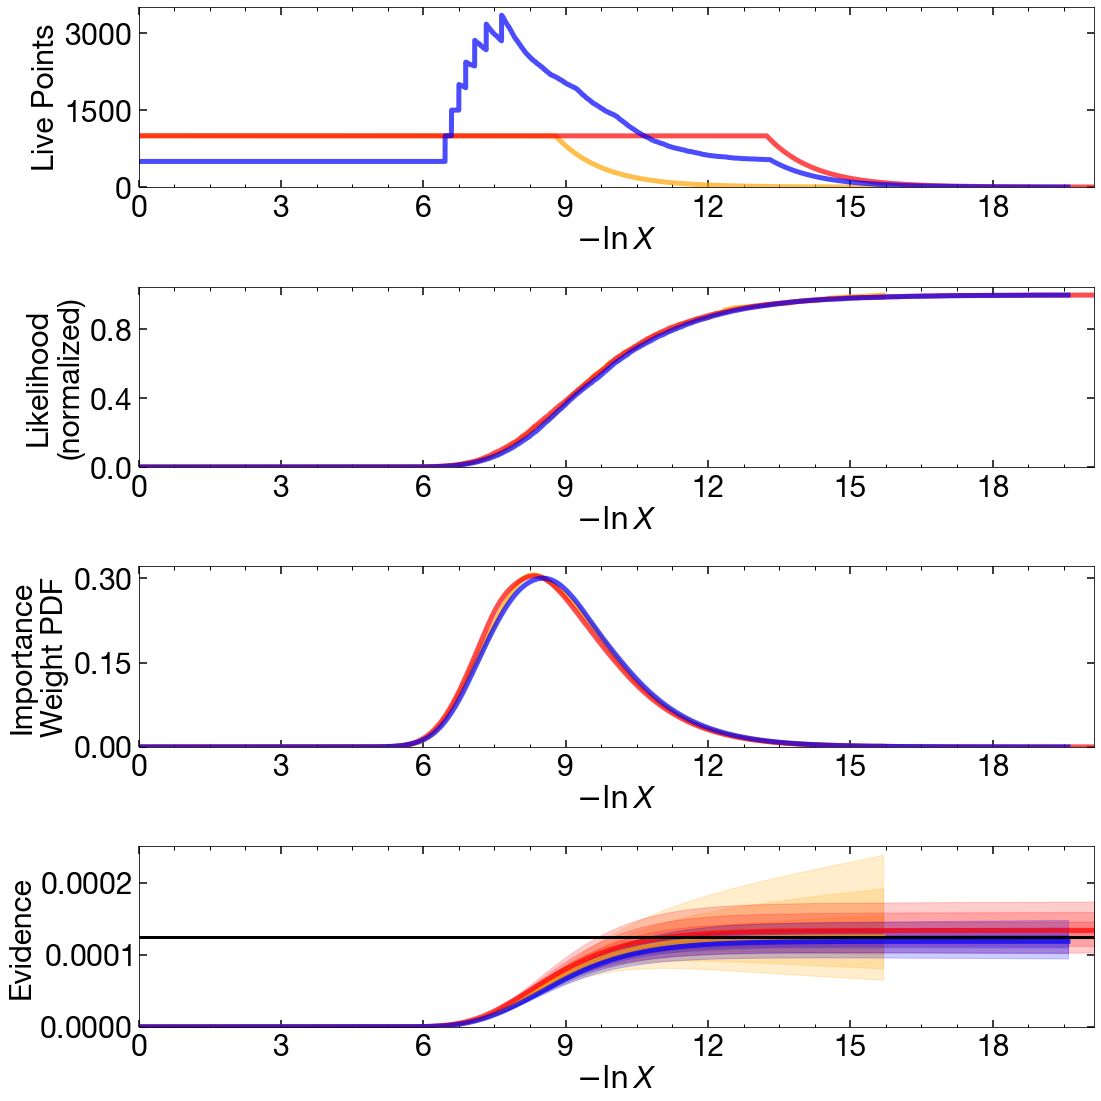

In [6]:
from dynesty import plotting as dyplot

# analytic evidence solution
lnz_truth = ndim * -np.log(2 * 10.)

# plotting results
fig, axes = dyplot.runplot(res, color='orange', mark_final_live=False)
fig, axes = dyplot.runplot(res2, color='red', mark_final_live=False,
                           fig=(fig, axes))
fig, axes = dyplot.runplot(dres, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, truth_color='black')
fig.tight_layout()

# Probing (Exact) Nested Sampling Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful (in some cases *exact*) uncertainty estimates on our resulting evidence (and posteriors) **using a single run**. We'll briefly demonstrate components of this below. See the documentation for additional details.

## Implementation in `dynesty`

`dynesty` contains a variety of useful utilities in the `utils` package, including a convenience function for extracting a number of samples from a run with equal weights (`resample_equal`), a convenience function for computing means and covariances (`mean_and_cov`), and a substitute for `np.random.choice` (`random_choice`).

In [7]:
dynesty.utils.__all__

['unitcheck',
 'resample_equal',
 'mean_and_cov',
 'quantile',
 'jitter_run',
 'resample_run',
 'simulate_run',
 'reweight_run',
 'unravel_run',
 'merge_runs',
 'kld_error',
 '_merge_two',
 '_get_nsamps_samples_n',
 'get_enlarge_bootstrap']

More importantly, however, it contains several functions that operate over the output `Results` dictionary from a nested sampling run in `dynesty` which implement the theoretical results discussed in this notebook.

## Deriving Statistical Uncertainties

**`jitter_run`** simulates the intrinsic, **statistical** uncertainties in nested sampling. These arise from uncertainties on the prior volume and are unique to nested sampling. `jitter_run` draws a large number of random variables from the corresponding (joint) prior volume distributions to simulate the set of possible prior volumes associated with each dead point from a particular run. It then returns a new `Results` dictionary with a new set of prior volumes, importance weights, and evidences (with errors). This approach of adding "jitter" to the weights works for both standard and dynamic runs and can capture complex covariances, as shown below.

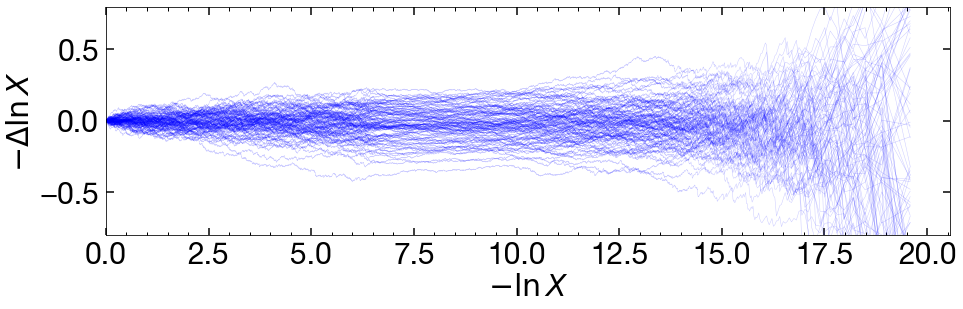

In [8]:
from dynesty import utils as dyfunc

# plot ln(prior volume) changes
plt.figure(figsize=(14, 5))
for i in range(100):
    dres_j = dyfunc.jitter_run(dres)
    plt.plot(-dres.logvol, -dres.logvol + dres_j.logvol, color='blue', 
             lw=0.5, alpha=0.2)
plt.xlim([0., None])
plt.ylim([-0.8, 0.8])
plt.xlabel(r'$-\ln X$')
plt.ylabel(r'$- \Delta \ln X$')
plt.tight_layout()

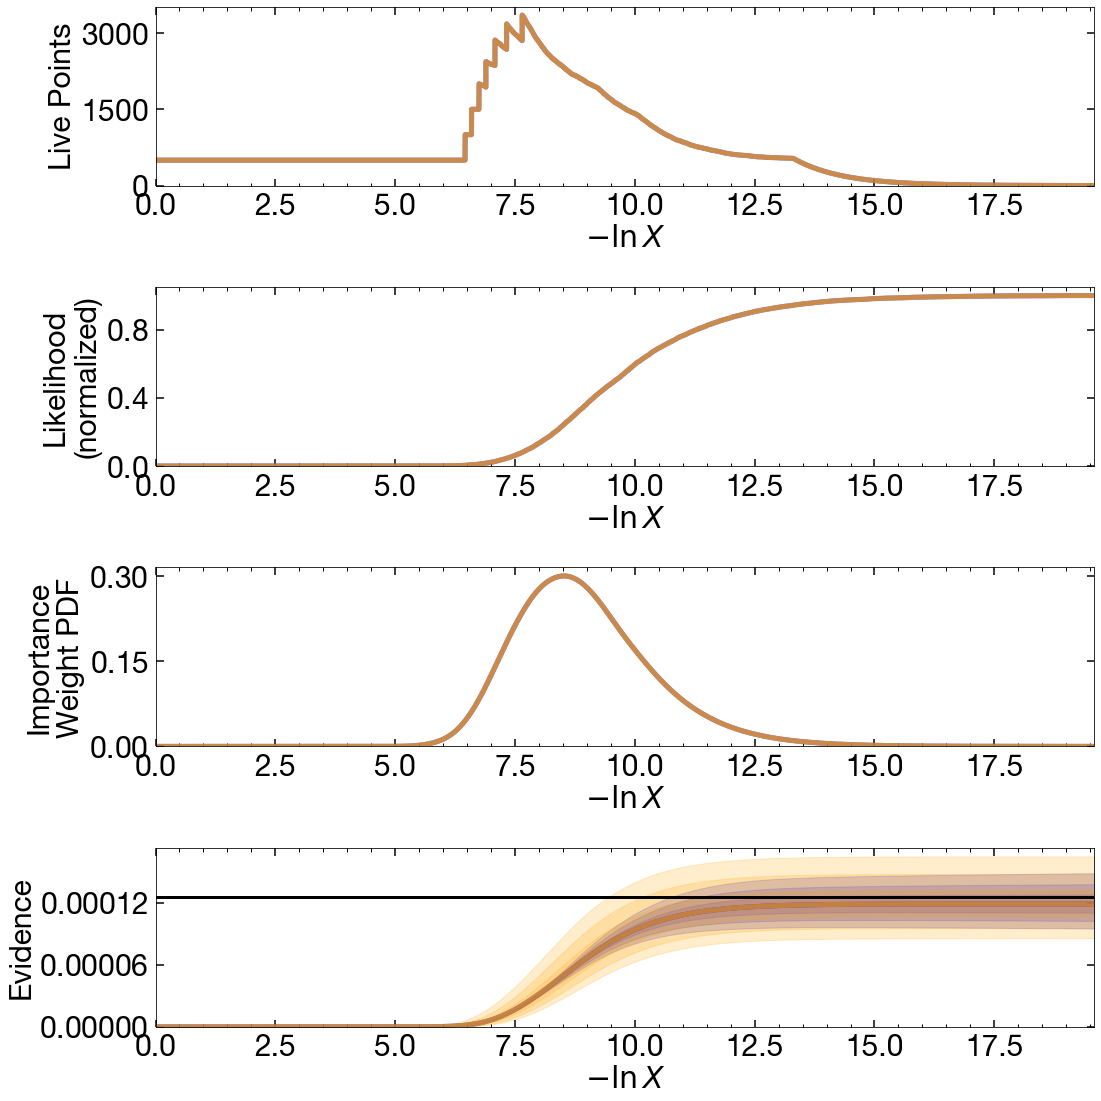

In [9]:
# compute ln(evidence) error
lnzs = np.zeros((100, len(dres.logvol)))
for i in range(100):
    dres_j = dyfunc.jitter_run(dres)
    lnzs[i] = np.interp(-dres.logvol, -dres_j.logvol, dres_j.logz)
lnzerr = np.std(lnzs, axis=0)

# plot comparison
dres_j = dres.asdict()
dres_j['logzerr'] = lnzerr
dres_j = Results(dres_j)
fig, axes = dyplot.runplot(dres, color='blue')
fig, axes = dyplot.runplot(dres_j, color='orange', 
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

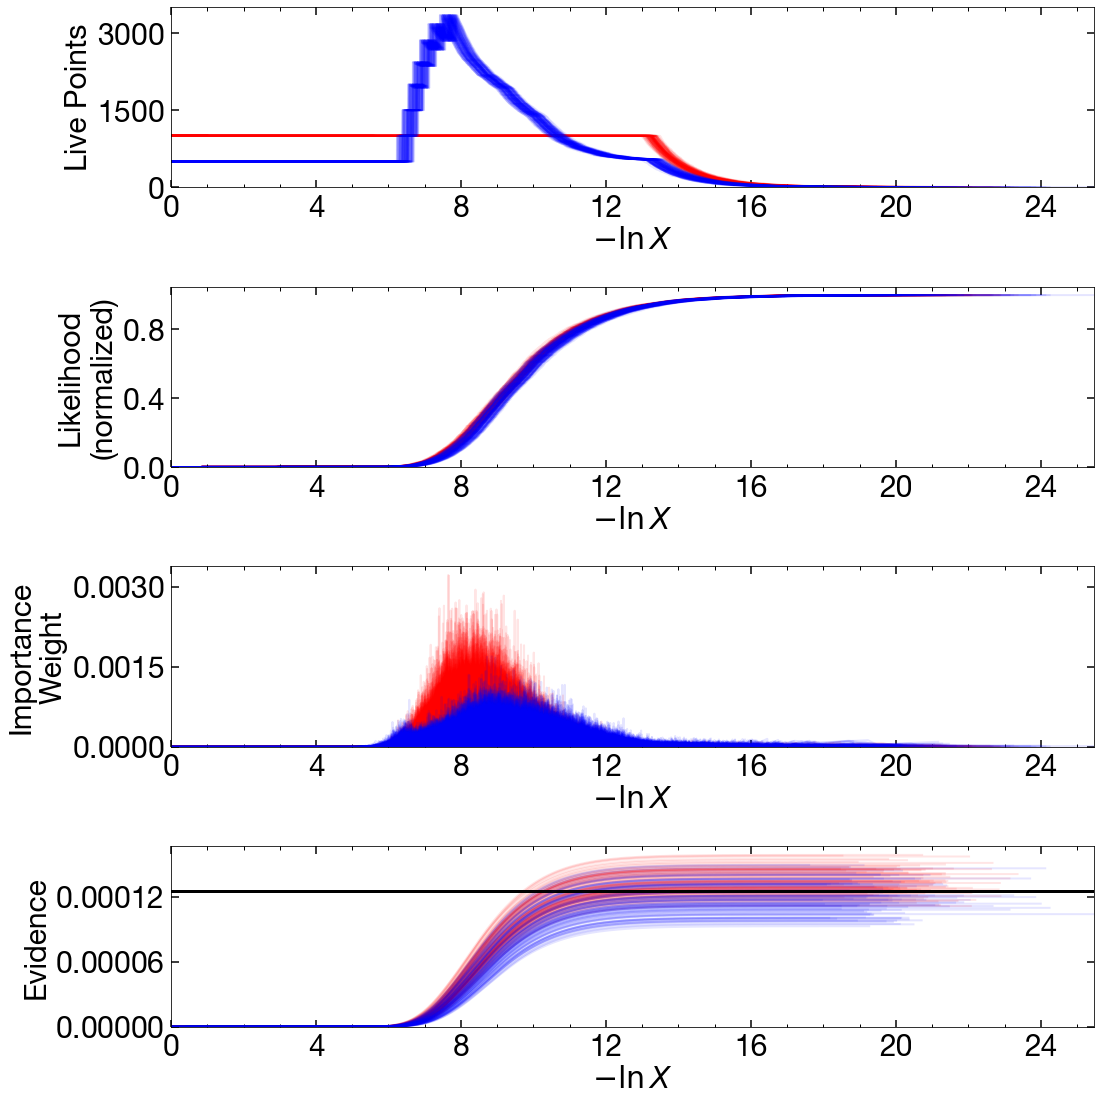

In [10]:
# overplot draws on summary plots
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(100):
    res2_j = dyfunc.jitter_run(res2)
    fig, axes = dyplot.runplot(res2_j, color='red', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(100):
    dres_j = dyfunc.jitter_run(dres)
    fig, axes = dyplot.runplot(dres_j, color='blue', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black', 
                               truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

# Deriving Sampling Uncertainties

## The "Trivially Parallelizable" Nature of Nested Sampling

One way to interpret nested sampling is that it is a scheme that takes a set of ordered likelihoods $0 < \mathcal{L}_1 < \dots < \mathcal{L}_N $ and associates them with a set of corresponding prior volumes $1 > X_1 > \dots > X_N > 0$ using a set number of live points $K$.

One neat property of nested sampling is that if we have two standard nested sampling runs with $K_1$ and $K_2$ live points, respectively, the combined set of ordered likelihoods has the same properties as the set of ordered likelihoods associated with a run using $K_1+K_2$ live points.

This property can be directly extended to combine any $M$ number of nested sampling runs.

This procedure can also be done in reverse, where a nested sampling run with $K$ live points can be "unraveled" into **"strands"**, $K$ runs with 1 live point, which can then be subsequently merged to form a run with any desired combination of live points. This process of **unraveling and merging** a nested sampling run can be done using the **`unravel_run`** and **`merge_runs`** function.

In [11]:
res_list = dyfunc.unravel_run(res)  # unravel run
res_merge = dyfunc.merge_runs(res_list)  # merge strands

Merge: 1000/1000      

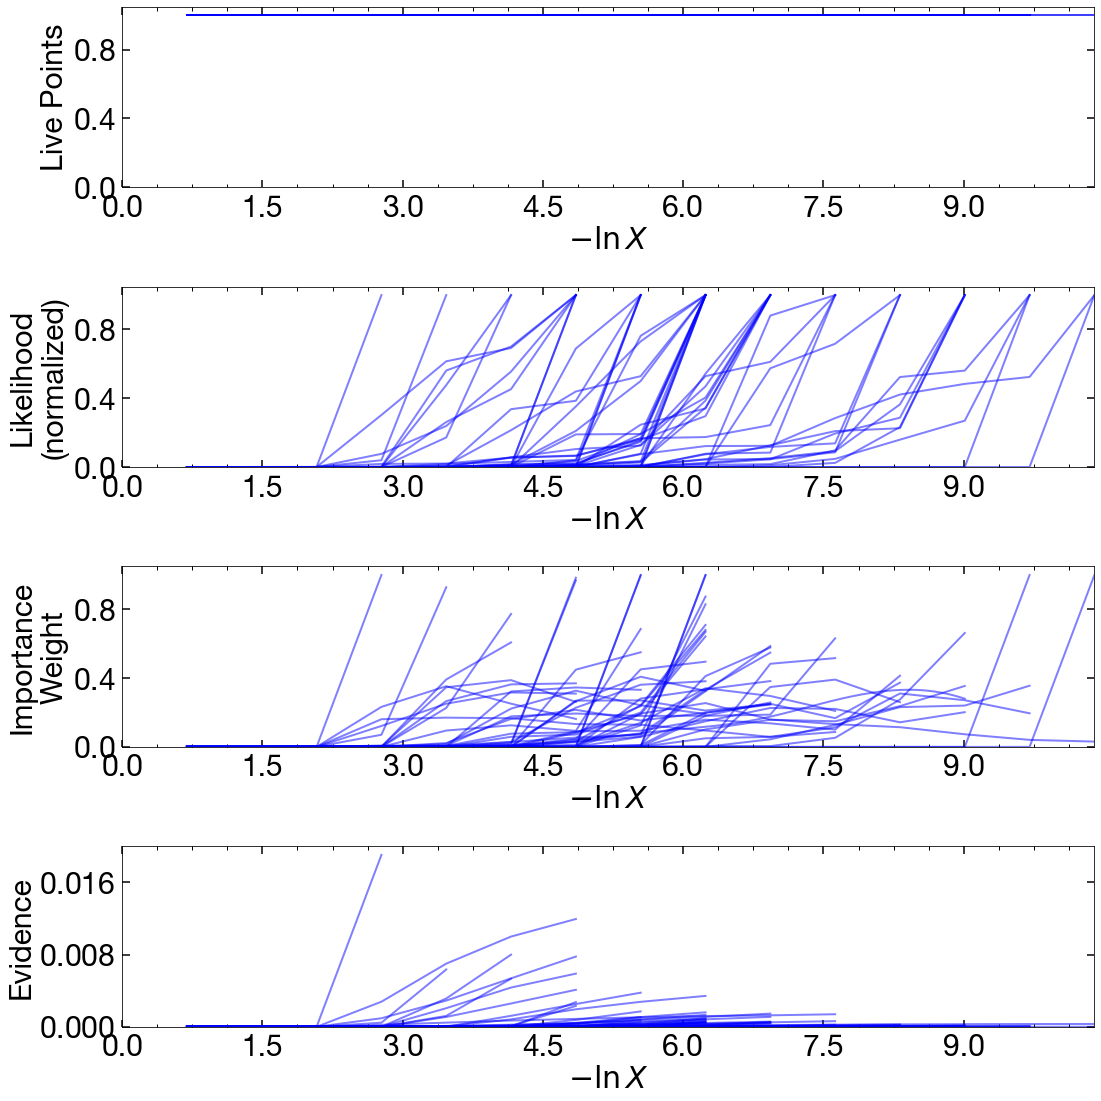

In [12]:
# plotting several strands
fig, axes = dyplot.runplot(res_list[0], plot_kwargs={'linewidth': 2, 'alpha': 0.5},
                           mark_final_live=False, lnz_error=False)
for r in res_list[1:50]:
    fig, axes = dyplot.runplot(r, plot_kwargs={'linewidth': 2, 'alpha': 0.5}, 
                               mark_final_live=False, lnz_error=False, kde=False,
                               fig=(fig, axes))
fig.tight_layout()

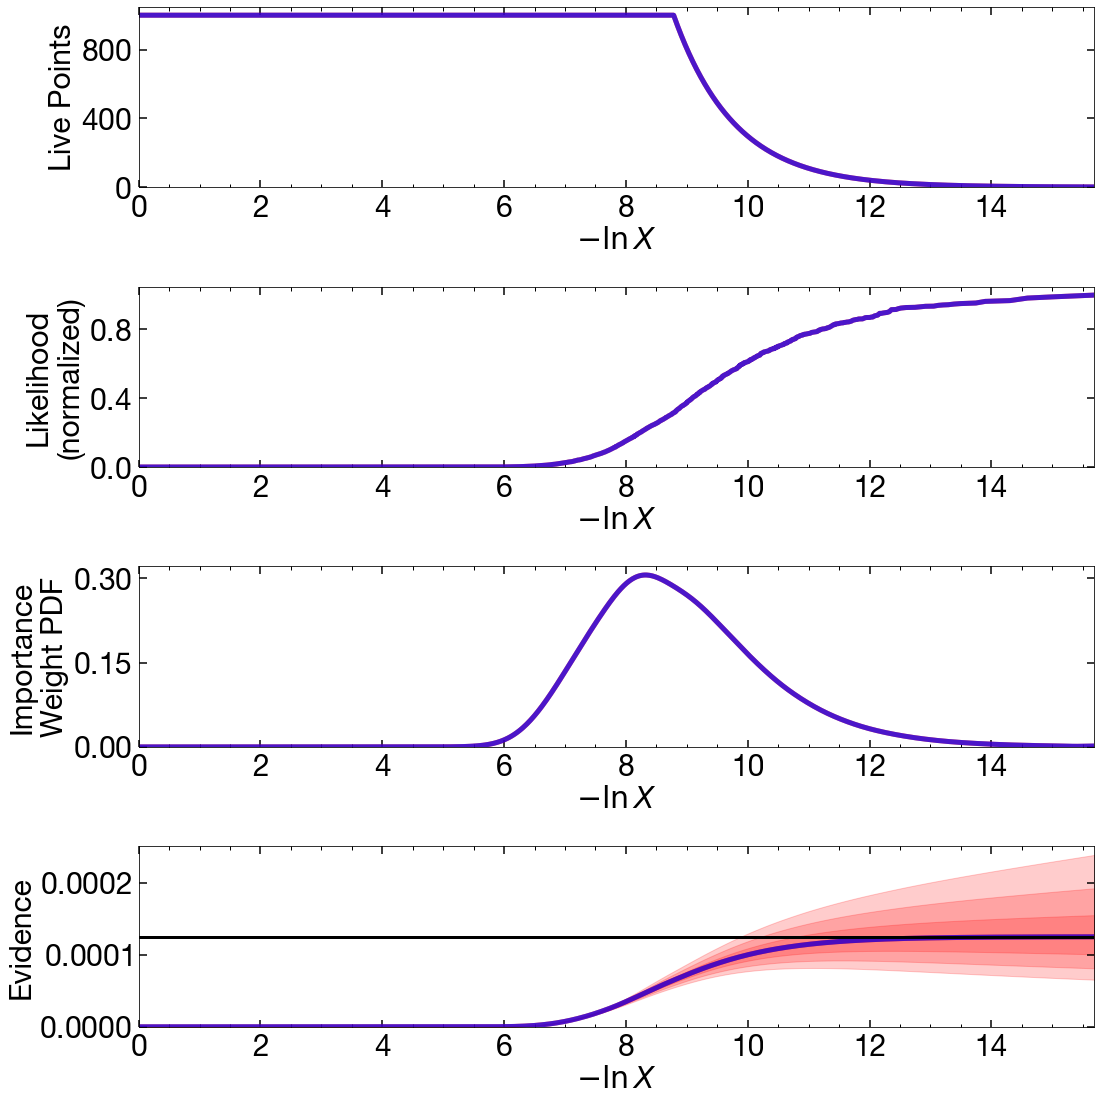

In [13]:
# plotting merged results
fig, axes = dyplot.runplot(res, color='red', mark_final_live=False)
fig, axes = dyplot.runplot(res_merge, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, lnz_error=False, truth_color='black')
fig.tight_layout()

### Extension to Dynamic Sampling

This "trivially parallelizable" property of nested sampling can also be directly extended to runs over different likelihood ranges.

Both `unravel_run` and `merge_runs` also work with dynamic nested sampling runs, although some of the provided anciliary quantities are not always valid (see the documentation for more details).

In [14]:
dres_list = dyfunc.unravel_run(dres)  # unravel run
dres_merge = dyfunc.merge_runs(dres_list)  # merge strands

Merge: 4000/4000      

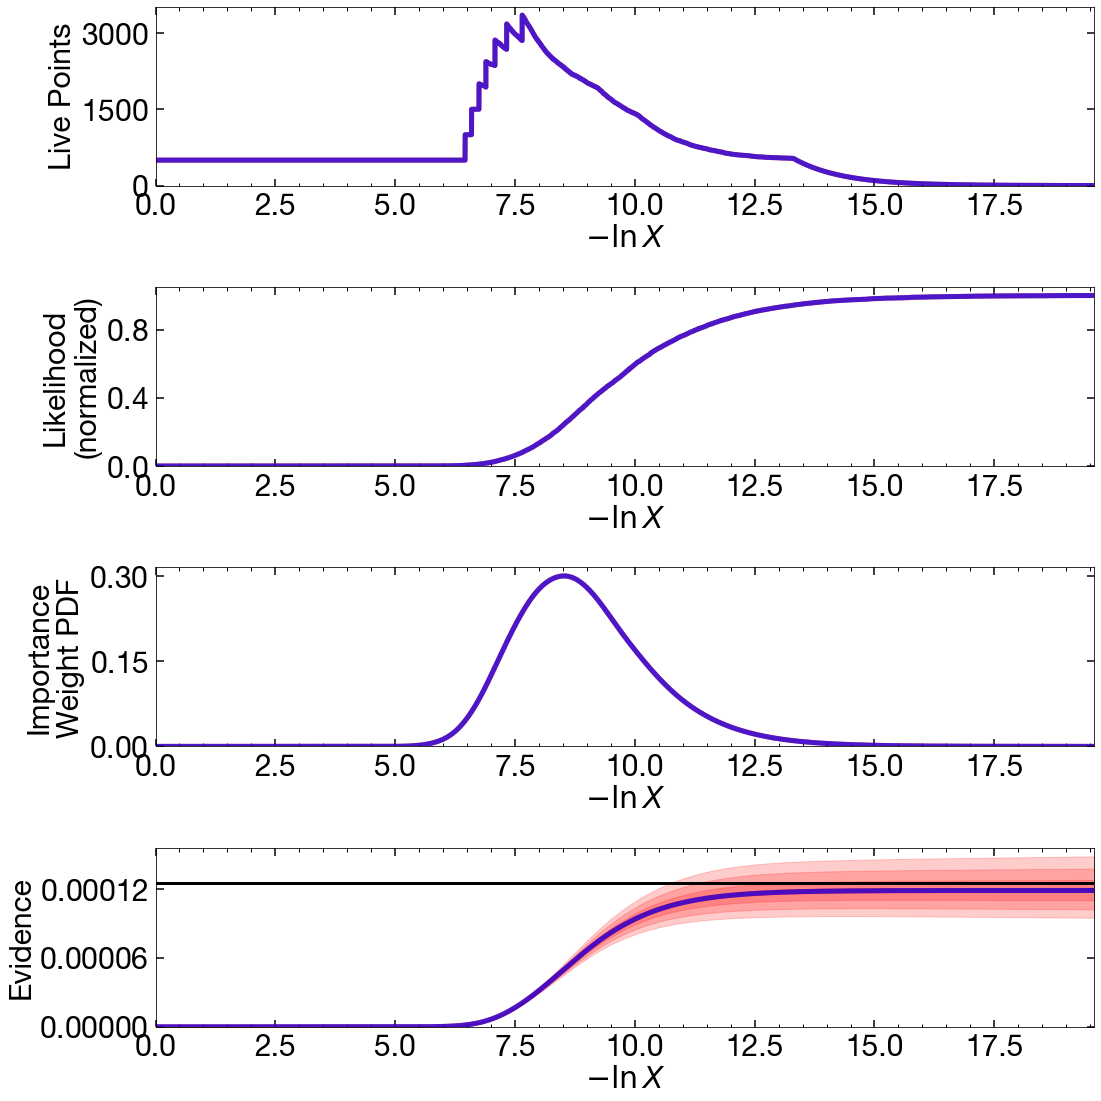

In [15]:
# plotting merged results
fig, axes = dyplot.runplot(dres, color='red', mark_final_live=False)
fig, axes = dyplot.runplot(dres_merge, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, lnz_error=False, truth_color='black')
fig.tight_layout()

### General Use

This process also works on runs from separate sources, such as combining our 3 separate runs.

Merge: 2/3     

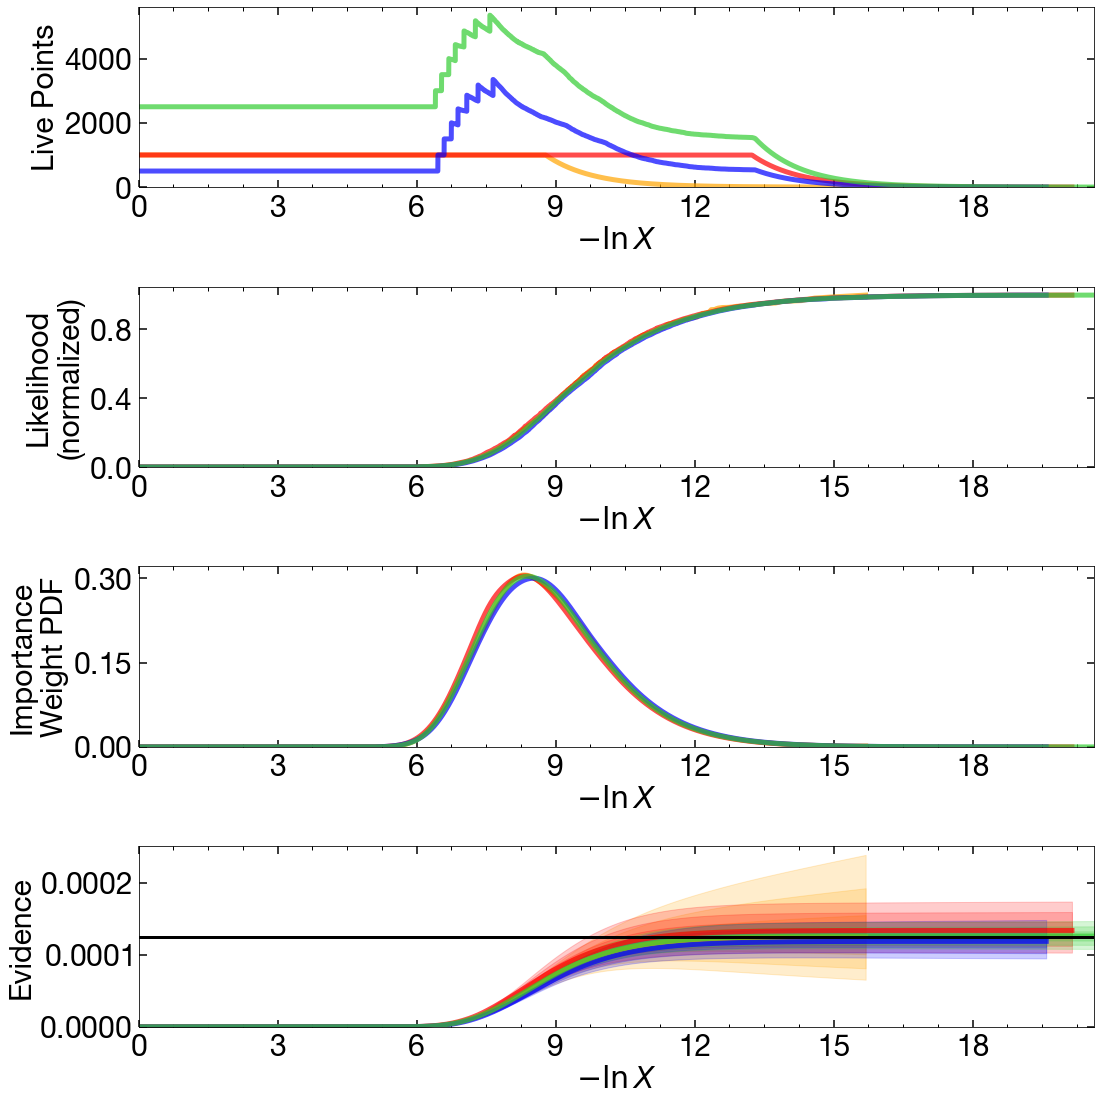

In [16]:
# merge runs
res_combined = dyfunc.merge_runs([res, res2, dres])

# plotting results
fig, axes = dyplot.runplot(res, color='orange', mark_final_live=False)
fig, axes = dyplot.runplot(res2, color='red', mark_final_live=False,
                           fig=(fig, axes))
fig, axes = dyplot.runplot(dres, color='blue', fig=(fig, axes))
fig, axes = dyplot.runplot(res_combined, color='limegreen', fig=(fig, axes),
                           lnz_truth=lnz_truth, truth_color='black')
fig.tight_layout()

## Bootstrapping Sampling Uncertainties

We can use the "trivially parallelizable" nature of nested sampling to our advantage to probe sampling errors using a bootstrap-like approach. Similar to `jitter_run`, users can construct these **resampled runs** using the **`resample_run`** function.

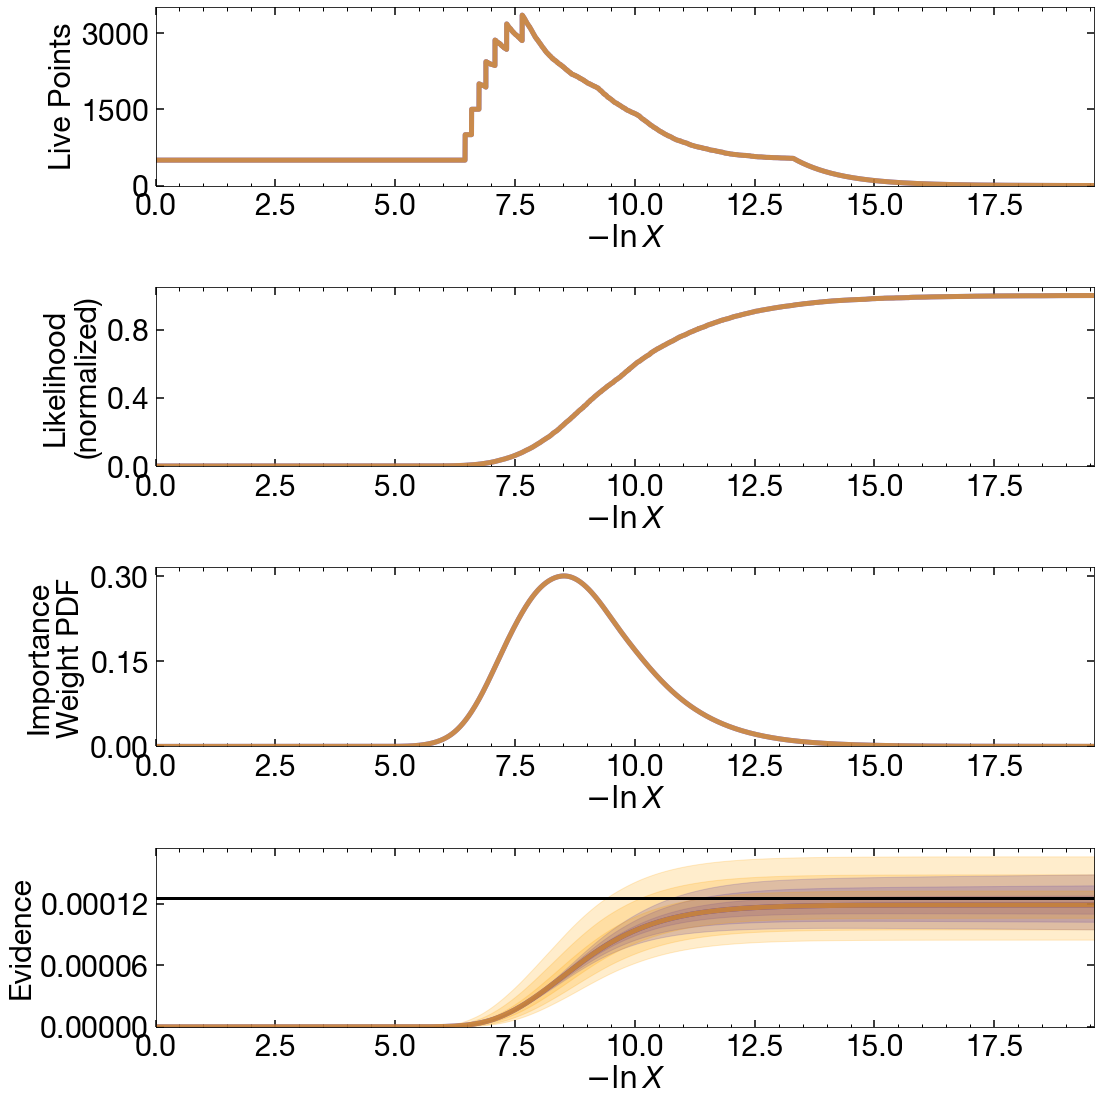

In [17]:
# compute ln(evidence) error
lnzs = np.zeros((100, len(dres.logvol)))
for i in range(100):
    dres_r = dyfunc.resample_run(dres)
    lnzs[i] = np.interp(-dres.logvol, -dres_r.logvol, dres_r.logz)
lnzerr = np.std(lnzs, axis=0)

# plot comparison
dres_r = dres.asdict()
dres_r['logzerr'] = lnzerr
dres_r= Results(dres_r)
fig, axes = dyplot.runplot(dres, color='blue')
fig, axes = dyplot.runplot(dres_r, color='orange', 
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

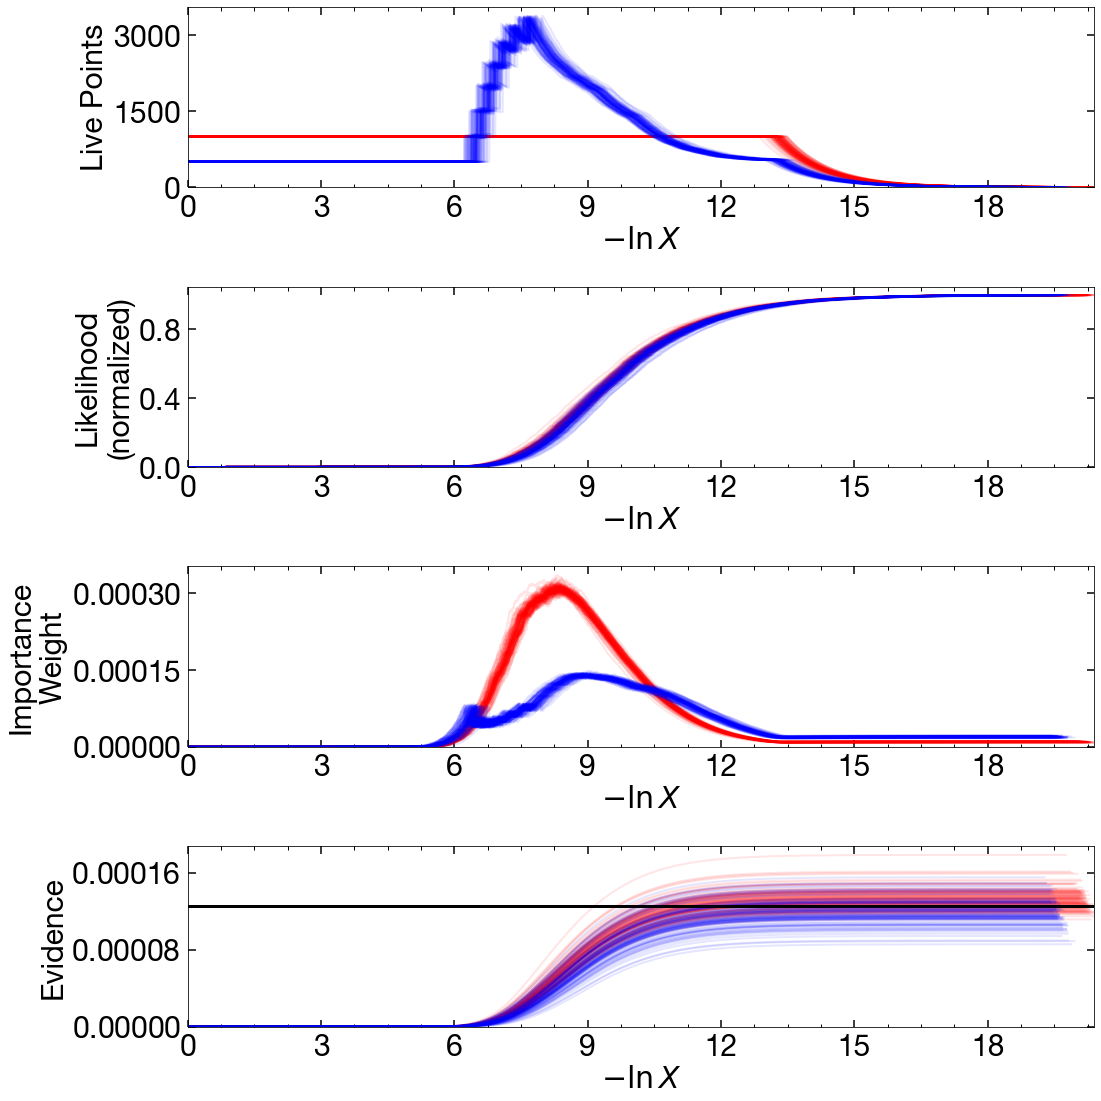

In [18]:
# overplot draws on summary plots
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(100):
    res2_r = dyfunc.resample_run(res2)
    fig, axes = dyplot.runplot(res2_r, color='red', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(100):
    dres_r = dyfunc.resample_run(dres)
    fig, axes = dyplot.runplot(dres_r, color='blue', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black', 
                               truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

# Combining Uncertainties

The total error budget in nested sampling is the (theoretical) variation present in repeated nested sampling runs combined with all possible prior volume realizations. This can be probed using **`simulate_run`** function, which just internally resamples the run (via `resample_run`) and then simulates the prior volumes (via `jitter_run`).

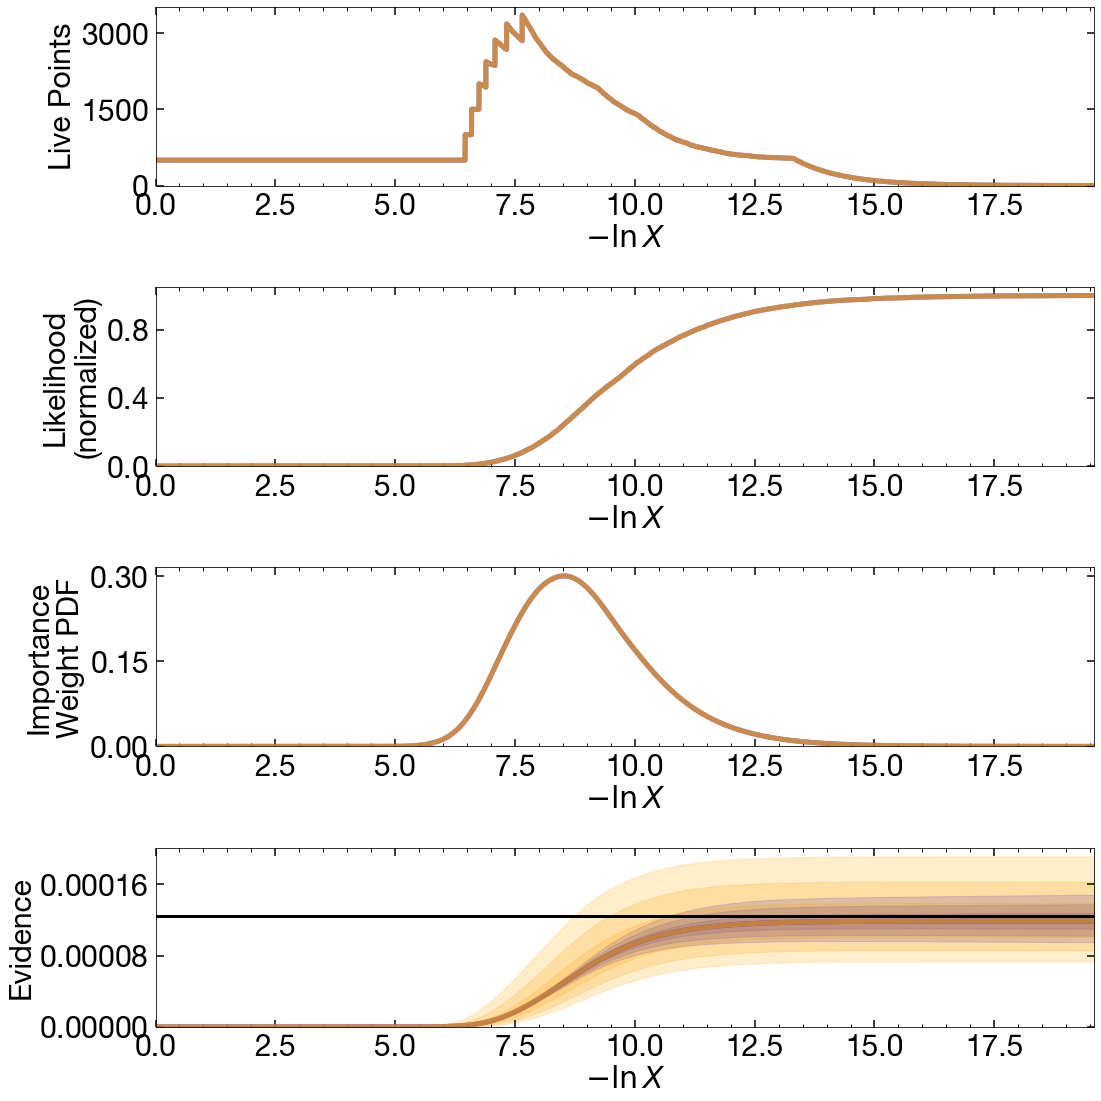

In [19]:
# compute ln(evidence) error
lnzs = np.zeros((100, len(dres.logvol)))
for i in range(100):
    dres_s = dyfunc.simulate_run(dres)
    lnzs[i] = np.interp(-dres.logvol, -dres_s.logvol, dres_s.logz)
lnzerr = np.std(lnzs, axis=0)

# plot comparison
dres_s = dres.asdict()
dres_s['logzerr'] = lnzerr
dres_s = Results (dres_s)
fig, axes = dyplot.runplot(dres, color='blue')
fig, axes = dyplot.runplot(dres_s, color='orange', 
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

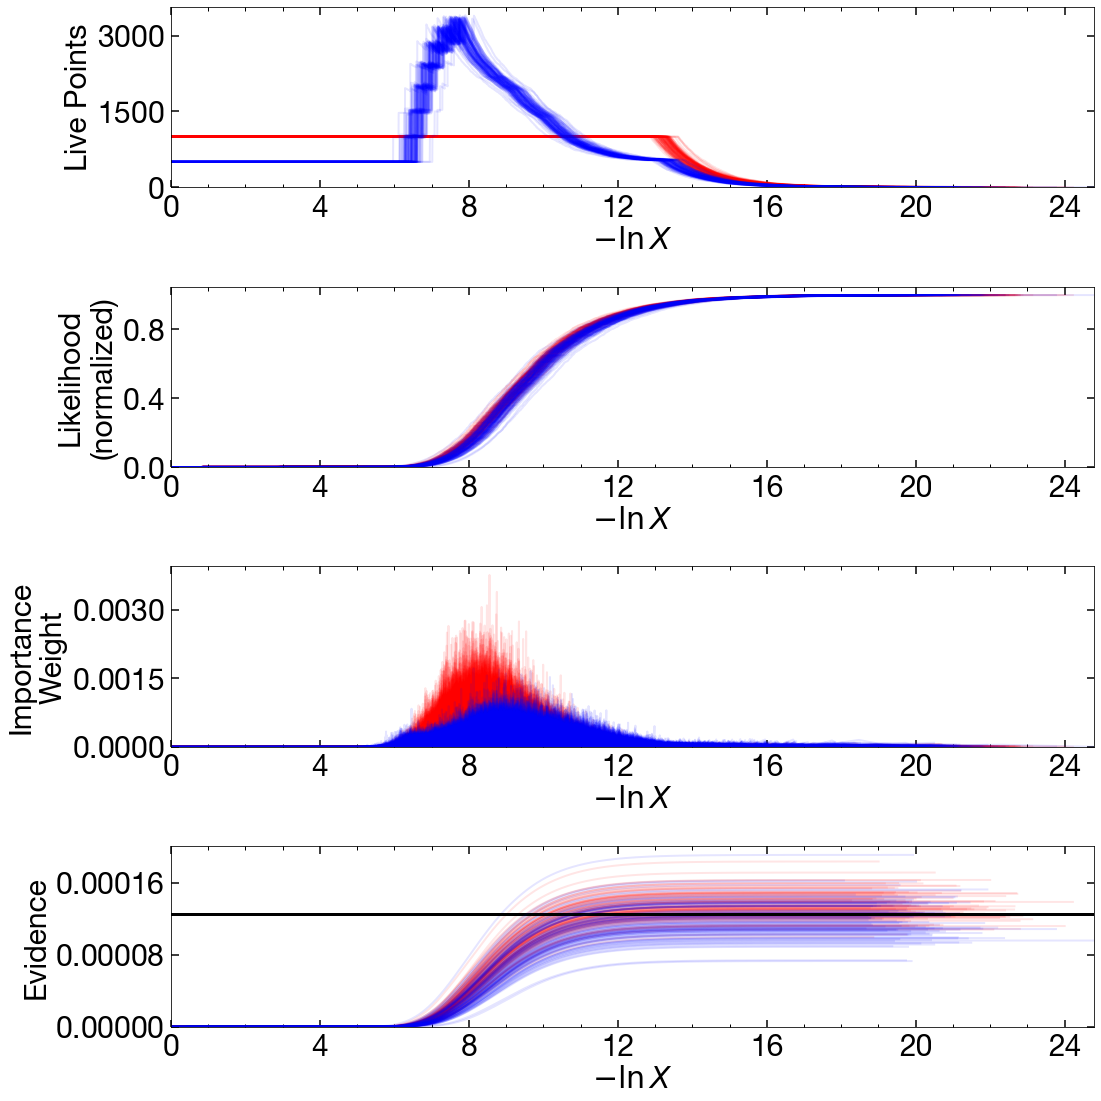

In [20]:
# overplot draws on summary plots
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(100):
    res2_s = dyfunc.simulate_run(res2)
    fig, axes = dyplot.runplot(res2_s, color='red', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(100):
    dres_s = dyfunc.simulate_run(dres)
    fig, axes = dyplot.runplot(dres_s, color='blue', kde=False,
                               plot_kwargs={'alpha': 0.1, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black',
                               truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

## Comparison Against Repeated Runs

As a final test to confirm our combined resampling/jittering approach produces robust results, we can compare our results computed using `jitter_run`, `resample_run`, and `simulate_run` directly to results computed from a large number of "repeated" nested sampling runs .

In [21]:
# generate repeat nested sampling runs
Nrepeat = 100
repeat_res = []
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, bound='single',
                                       rstate=rstate)
for i in range(Nrepeat):
    dsampler.reset()
    dsampler.run_nested(nlive_init=50, nlive_batch=50,
                        print_progress=False, maxiter=5000, use_stop=False)
    sys.stderr.write('{0} '.format(i))
    repeat_res.append(dsampler.results)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [22]:
# establish our comparison run
dsampler.reset()
dsampler.run_nested(nlive_init=50, nlive_batch=50,
                    print_progress=False, maxiter=5000, use_stop=False)
r = dsampler.results

In [23]:
# jittered runs
jitter_res = []
for i in range(Nrepeat):
    jitter_res.append(dyfunc.jitter_run(r, rstate=rstate, approx=True))

# resampled runs
rsamp_res = []
for i in range(Nrepeat):
    rsamp_res.append(dyfunc.resample_run(r, rstate=rstate))
    
# simulated runs
sim_res = []
for i in range(Nrepeat):
    sim_res.append(dyfunc.simulate_run(r, rstate=rstate, approx=True))

As an initial test, let's compare the estimated $\ln \hat{\mathcal{Z}}$ from each set of runs. We expect that each pair of errors should be broadly similar. By construction, our initial analytic approximation should be similar to the errors from our jittered weights derived from our repeated runs, since both probe sampling uncertainties while ignoring prior volume uncertainties. And the combined "simulated" errors should be similar to our repeated runs using jittered weights since both probe statistical and sampling uncertainties simultaneously.

In [24]:
# compare evidence estimates

# analytic first-order approximation
lnz_mean, lnz_std = r.logz[-1], r.logzerr[-1]
print('Approx.:     {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

# jittered draws
lnz_arr = [results.logz[-1] for results in jitter_res]
lnz_mean, lnz_std = np.mean(lnz_arr), np.std(lnz_arr)
print('Sim.:        {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

# resampled draws
lnz_arr = [results.logz[-1] for results in rsamp_res]
lnz_mean, lnz_std = np.mean(lnz_arr), np.std(lnz_arr)
print('Resamp.:     {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

# repeated runs
lnz_arr = [results.logz[-1] for results in repeat_res]
lnz_mean, lnz_std = np.mean(lnz_arr), np.std(lnz_arr)
print('Rep. (mean): {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

# simulated draws
lnz_arr = [results.logz[-1] for results in sim_res]
lnz_mean, lnz_std = np.mean(lnz_arr), np.std(lnz_arr)
print('Comb.:       {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

# jittered draws from repeated runs
lnz_arr = [dyfunc.jitter_run(results).logz[-1] for results in repeat_res]
lnz_mean, lnz_std = np.mean(lnz_arr), np.std(lnz_arr)
print('Rep. (sim.): {:6.3f} +/- {:6.3f}'.format(lnz_mean, lnz_std))

Approx.:     -9.063 +/-  0.133
Sim.:        -9.147 +/-  0.199
Resamp.:     -9.056 +/-  0.192
Rep. (mean): -8.963 +/-  0.234
Comb.:       -9.080 +/-  0.311
Rep. (sim.): -9.013 +/-  0.316


While there are some slight differences, overall we see that each method behaves as expected. As further confirmation, we can also look at the first moments of the posterior.

In [25]:
# compare posterior first moments

# jittered draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[0]
                  for results in jitter_res])
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Sim.:        {0} +/- {1}'.format(x_mean, x_std))

# resampled draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[0]
                  for results in rsamp_res])
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Resamp.:     {0} +/- {1}'.format(x_mean, x_std))

# repeated runs
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[0]
                  for results in repeat_res])
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Rep. (mean): {0} +/- {1}'.format(x_mean, x_std))

# simulated draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[0]
                  for results in sim_res])
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Comb.:       {0} +/- {1}'.format(x_mean, x_std))

# jittered draws from repeated runs
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(dyfunc.jitter_run(results).logwt))[0]
                  for results in repeat_res])
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Rep. (sim.): {0} +/- {1}'.format(x_mean, x_std))

Sim.:        [0.029 0.027 0.026] +/- [0.016 0.016 0.015]
Resamp.:     [0.028 0.026 0.026] +/- [0.014 0.014 0.014]
Rep. (mean): [0.002 0.002 0.002] +/- [0.014 0.015 0.015]
Comb.:       [0.03  0.029 0.029] +/- [0.021 0.021 0.021]
Rep. (sim.): [0.001 0.002 0.002] +/- [0.02  0.021 0.021]


Again, the behavior looks as expected. As a final check, let's examine the second moment of the posterior.

In [26]:
# compare posterior second (diagonal) moments

# jittered draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[1]
                  for results in jitter_res])
x_arr = [np.diag(x) for x in x_arr]
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Sim.:        {0} +/- {1}'.format(x_mean, x_std))

# resampled draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[1]
                  for results in rsamp_res])
x_arr = [np.diag(x) for x in x_arr]
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Resamp.:     {0} +/- {1}'.format(x_mean, x_std))

# repeated runs
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[1]
                  for results in repeat_res])
x_arr = [np.diag(x) for x in x_arr]
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Rep. (mean): {0} +/- {1}'.format(x_mean, x_std))

# simulated draws
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(results.logwt))[1]
                  for results in sim_res])
x_arr = [np.diag(x) for x in x_arr]
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Comb.:       {0} +/- {1}'.format(x_mean, x_std))

# jittered draws from repeated runs
x_arr = np.array([dyfunc.mean_and_cov(results.samples, 
                  weights=np.exp(dyfunc.jitter_run(results).logwt))[1]
                  for results in repeat_res])
x_arr = [np.diag(x) for x in x_arr]
x_mean = np.round(np.mean(x_arr, axis=0), 3)
x_std = np.round(np.std(x_arr, axis=0), 3)
print('Rep. (sim.): {0} +/- {1}'.format(x_mean, x_std))

Sim.:        [0.992 0.996 0.983] +/- [0.025 0.024 0.024]
Resamp.:     [0.99  0.994 0.98 ] +/- [0.023 0.022 0.023]
Rep. (mean): [0.993 0.994 0.992] +/- [0.025 0.024 0.025]
Comb.:       [0.994 0.996 0.983] +/- [0.036 0.035 0.035]
Rep. (sim.): [0.994 0.995 0.993] +/- [0.031 0.032 0.031]


Again, we see that our errors behave as expected.

# Posterior Uncertainties

KL divergences between nested sampling runs can be computed in `dynesty` using the **`kl_divergence`** and **`kld_error`** functions. The former is slower but slightly more flexible while the latter generates comparisons directly over realizations of a single run.

In [27]:
klds = []
for i in range(Nrepeat):
    kld = dyfunc.kld_error(res2, error='simulate')
    klds.append(kld)
    sys.stderr.write('{0} '.format(i))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

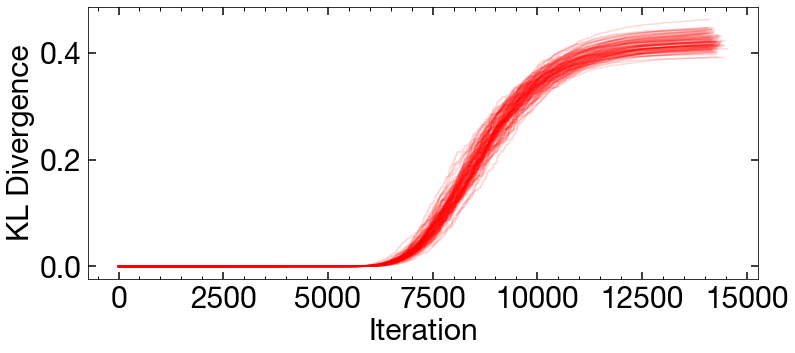

In [28]:
# plot KL divergence
plt.figure(figsize=(12, 5))
for kld in klds:
    plt.plot(kld, color='red', alpha=0.15)
plt.xlabel('Iteration')
plt.ylabel('KL Divergence');

The behavior appears qualitatively similar to our evidence results, since the majority of the KL divergence is coming from summing over the bulk of the posterior mass. The variation in these results are shown below.

Mean:    0.422
Std:     0.014
Std(%):  3.248


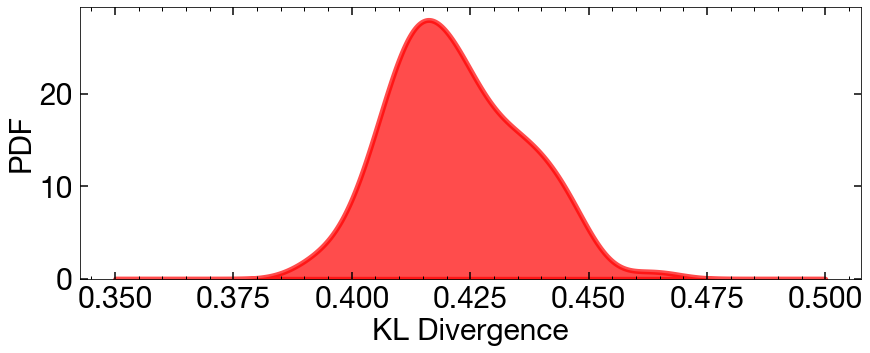

In [29]:
# compute KLD kernel density estimate
kl_div = [kld[-1] for kld in klds]
kde = gaussian_kde(kl_div)

# plot results
plt.figure(figsize=(14, 5))
x = np.linspace(0.35, 0.5, 1000)
plt.fill_between(x, kde.pdf(x), color='red', alpha=0.7, lw=5)
plt.ylim([0., None])
plt.xlabel('KL Divergence')
plt.ylabel('PDF')

# summarize results
kl_div_mean, kl_div_std = np.mean(kl_div), np.std(kl_div)
print('Mean:   {:6.3f}'.format(kl_div_mean))
print('Std:    {:6.3f}'.format(kl_div_std))
print('Std(%): {:6.3f}'.format(kl_div_std / kl_div_mean * 100.))

How does our dynamic sampling run *with the exact same number of samples* compare?

In [30]:
klds2 = []
for i in range(Nrepeat):
    kld2 = dyfunc.kld_error(dres, error='simulate')
    klds2.append(kld2)
    sys.stderr.write('{0} '.format(i))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Mean:    0.425
Std:     0.012
Std(%):  2.729


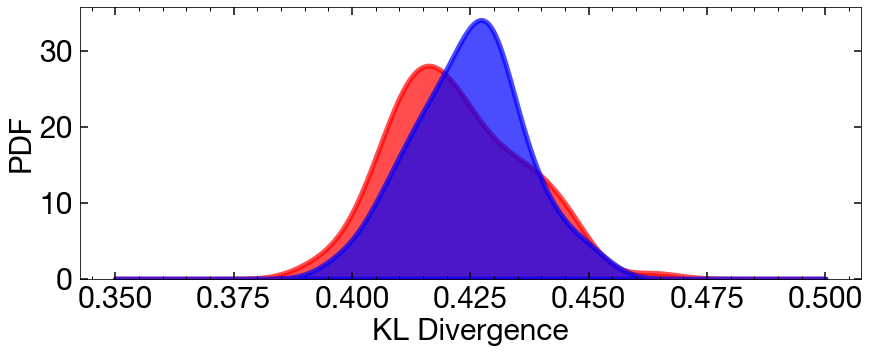

In [31]:
# compute KLD kernel density estimate
kl_div2 = [kld2[-1] for kld2 in klds2]
kde2 = gaussian_kde(kl_div2)

# plot results
plt.figure(figsize=(14, 5))
plt.fill_between(x, kde.pdf(x), color='red', alpha=0.7, lw=5)
plt.fill_between(x, kde2.pdf(x), color='blue', alpha=0.7, lw=5)
plt.ylim([0., None])
plt.xlabel('KL Divergence')
plt.ylabel('PDF')

# summarize results
kl_div2_mean, kl_div2_std = np.mean(kl_div2), np.std(kl_div2)
print('Mean:   {:6.3f}'.format(kl_div2_mean))
print('Std:    {:6.3f}'.format(kl_div2_std))
print('Std(%): {:6.3f}'.format(kl_div2_std / kl_div2_mean * 100.))

As expected, while the mean value is almost identical, the fractional standard deviation is lower.

# Summary

Nested sampling results contain two sources of error: statistical uncertainties associated with the unknown prior volume and sampling uncertainties associated with Monte Carlo noise. Both of these uncertainties, however, can be quantified *using a single (dynamic) nested sampling run*. The statistical uncertainties can be probed directly by simulating the prior volumes, while the sampling uncertainties can be probed using a bootstrap-like resampling of the unique particles (live points) used in a given run. Individual realizations can be computed using functions in the `utils` module, which can be used to check posterior moment stability (via, e.g., `mean_and_cov`) and posterior "noise" (via, e.g., `kld_error`).